In [ ]:
from google.colab import drive
drive.mount('/content/drive') #/any folder/drive

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras import layers
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
AUTO = tf.data.AUTOTUNE
resize = 224
cropsize = 224
batchsize = 64

In [ ]:
sds, _ = tfds.load("caltech101", split=["train[:5%]", "train[5%:]"], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.0T9ZBE_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.0T9ZBE_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [ ]:
resnet_url = "https://tfhub.dev/google/bit/m-r50x1/1"
resnet = hub.KerasLayer(resnet_url)

In [ ]:
ref_url = "https://tfhub.dev/google/bit/m-r50x1/imagenet21k_classification/1"
ref = hub.KerasLayer(ref_url)

In [ ]:
!wget https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('imagenet21k_wordnet_lemmas.txt', 'r') as f:
  for i in range(22000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2025-03-19 10:48:47--  https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522999 (511K) [text/plain]
Saving to: ‘imagenet21k_wordnet_lemmas.txt.2’

imagenet21k_wordnet 100%[===================>] 510.74K   326KB/s    in 1.6s    

2025-03-19 10:48:51 (326 KB/s) - ‘imagenet21k_wordnet_lemmas.txt.2’ saved [522999/522999]



In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, [375, 375])
    #reshape_img = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    img = tf.image.convert_image_dtype(image, tf.float32)
    #img = img / 255.0
    return (img, label)

In [ ]:
sdl = (
    sds.map(preprocess, num_parallel_calls=AUTO)
    .batch(batchsize)
    .prefetch(AUTO)
)

In [ ]:
MAX_PREDS = 5
MIN_SCORE = 0

def show_preds(logits, image):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    classes.append(imagenet_int_to_str[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

In [ ]:
feature = [resnet(batch[0]) for i, batch in enumerate(dl)]
feature = np.vstack(feature[:-1])

label = [batch[1] for i, batch in enumerate(dl)]
label = np.hstack(label[:-1])

img = [batch[0].numpy() for i, batch in enumerate(dl)]
img = np.vstack(img[:-1])

print(feature.shape, label.shape)

(448, 2048) (448,)


In [ ]:
feature = [resnet(batch[0]) for i, batch in enumerate(sdl)]
feature = np.vstack(feature[:-1])

label = [batch[1] for i, batch in enumerate(sdl)]
label = np.hstack(label[:-1])

img = [batch[0].numpy() for i, batch in enumerate(sdl)]
img = np.vstack(img[:-1])

print(feature.shape, label.shape, img.shape)

(128, 2048) (128,) (128, 375, 375, 3)


In [ ]:
np.save("/content/drive/MyDrive/BiT/feature", feature)
np.save("/content/drive/MyDrive/BiT/label", label)
np.save("/content/drive/MyDrive/BiT/img", img)

In [ ]:
##skipping previous steps
#feature = np.load("/content/drive/MyDrive/BiT/feature.npy")
#label = np.load("/content/drive/MyDrive/BiT/label.npy")
#img = np.load("/content/drive/MyDrive/BiT/img.npy")

In [ ]:
#result of predicting the class of image
for i in img:
  ig = i.astype(int)
  i = tf.reshape(i, [1, i.shape[0], i.shape[1], i.shape[2]])
  i = i * 255.0
  logits = ref(i)
  temp = tf.sort(logits, direction = "DESCENDING")
  show_preds(logits, ig)

Due to output result is too large, here will only show some of the output result.

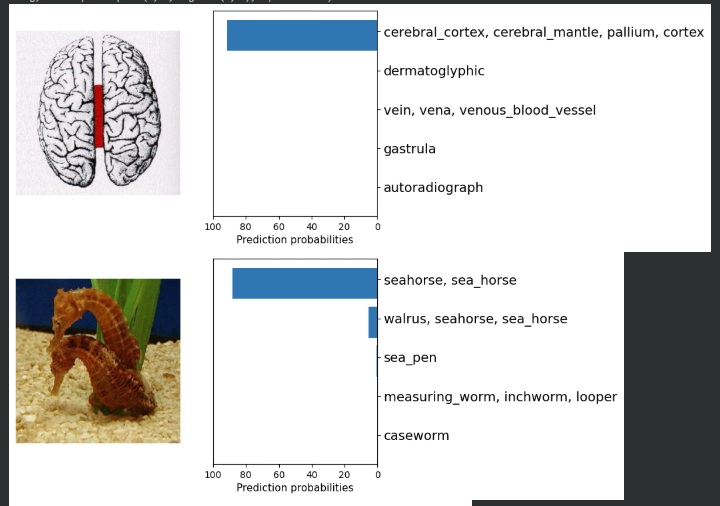

In [ ]:
#to confirm the cosine similarity of two image features(which is same class) is high
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for i in range(128):
  if (label[3] == label[i]):
    print(cos_sim(feature[3], feature[i]))

1.0
0.6952647
0.679967
0.7172134
